In [ ]:
! python -m pip install seaborn

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


{'Media': lesion_id              1529.933856
smoke                     0.135207
drink                     0.246319
age                      60.464752
pesticide                 0.399598
skin_cancer_history       0.455823
cancer_history            0.521419
has_piped_water           0.617805
has_sewage_system         0.566265
fitspatrick               2.265730
diameter_1               11.897055
diameter_2                8.852209
biopsed                   0.583986
dtype: float64, 'Desviacion': lesion_id              1196.285644
smoke                     0.342060
drink                     0.431011
age                      15.894866
pesticide                 0.489980
skin_cancer_history       0.498211
cancer_history            0.499708
has_piped_water           0.486087
has_sewage_system         0.495755
fitspatrick               0.729029
diameter_1                8.634492
diameter_2                5.797036
biopsed                   0.493003
dtype: float64, 'Faltantes': patient_id           

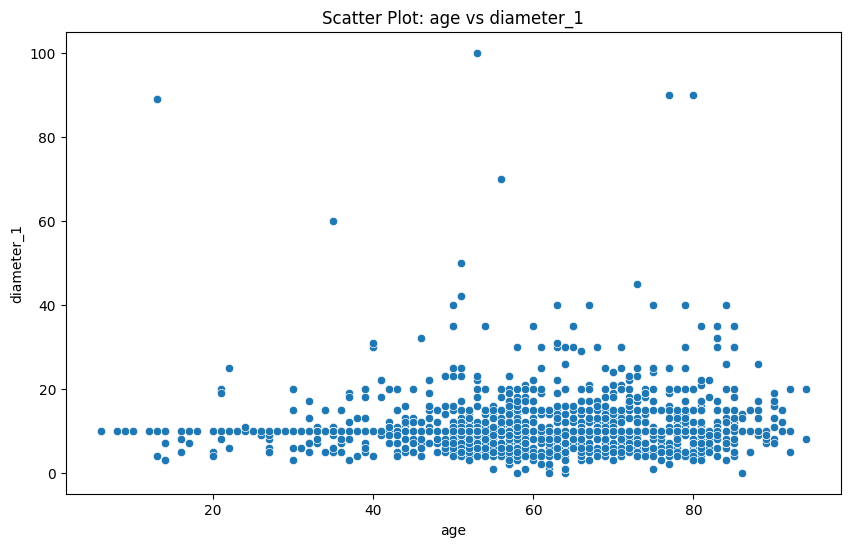

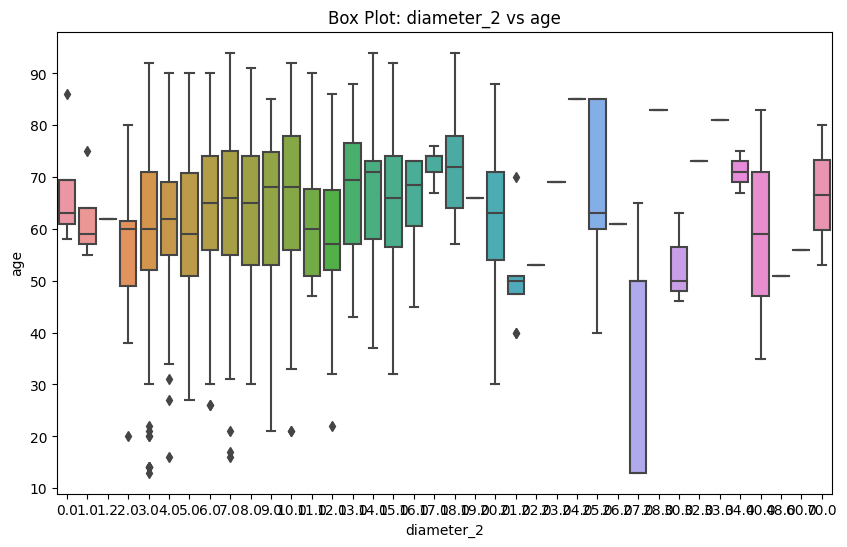

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Evaluación Naive Bayes:
Reporte de Métricas:
              precision    recall  f1-score   support

      FEMALE       1.00      0.48      0.65       312
        MALE       0.48      1.00      0.65       148

    accuracy                           0.65       460
   macro avg       0.74      0.74      0.65       460
weighted avg       0.83      0.65      0.65       460

Evaluación Regresión Logística:
Reporte de Métricas:
              precision    recall  f1-score   support

      FEMALE       0.91      0.92      0.91       312
        MALE       0.83      0.80      0.81       148

    accuracy                           0.88       460
   macro avg       0.87      0.86      0.86       460
weighted avg       0.88      0.88      0.88       460

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Mejores parámetros (Logistic Regression): {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import joblib

class Preprocesamiento:
    def __init__(self, ruta, usar_muestra=False, columnas=None):
        self.data = self.cargar_datos(ruta, usar_muestra, columnas)

    @staticmethod

    def cargar_datos (ruta, usar_muestra=False, columnas=None):
        df= pd.read_csv(ruta)
        if usar_muestra:
            df= df.sample(frac=0.1, random_state=42)
        if columnas:
            df = df[columnas]
        return df

    def diagnostico_estadistico(self, media=False, desviacion=False, faltantes=False, maximo=False, minimo=False, descriptores=None):
        if descriptores is None:
            descriptores = self.data.columns

        resultado = {}

        if media:
            resultado['Media'] = self.data[descriptores].mean()

        if desviacion:
            resultado['Desviacion'] = self.data[descriptores].std()

        if faltantes:
            resultado['Faltantes'] = self.data[descriptores].isnull().sum()

        if maximo:
            resultado['Maximo']= self.data[descriptores].max()

        if minimo:
            resultado['Minimo']= self.data[descriptores].min()

        return resultado

    def imputar_datos(self, descriptores, estrategias):
        
        for descriptor, estrategia in zip(descriptores, estrategias):
            imputer = SimpleImputer(strategy=estrategia)
            self.data[descriptor] = imputer.fit_transform(self.data[[descriptor]])
        

    def graficar(self, var1, var2=None, tipo='scatter', guardar=False, nombre_archivo=None):
        
        plt.figure(figsize=(10, 6))
        if tipo == 'scatter':
            sns.scatterplot(x=var1, y=var2, data=self.data)
            plt.title(f'Scatter Plot: {var1} vs {var2}')
            plt.xlabel(var1)
            plt.ylabel(var2)
        elif tipo == 'box':
            sns.boxplot(x=var1, y=var2, data=self.data)
            plt.title(f'Box Plot: {var1} vs {var2}')
            plt.xlabel(var1)
            plt.ylabel(var2)
        else:
            raise ValueError("Tipo de gráfico no reconocido. Use 'scatter' o 'box'.")

        if guardar and nombre_archivo:
            plt.savefig(nombre_archivo)
        else:
            plt.show()

    def normalizar_escalar(self, descriptores, estrategia='zscore'):
        
        if estrategia == 'zscore':
            scaler = StandardScaler()
        elif estrategia == 'minmax':
            scaler = MinMaxScaler()
        
        self.data[descriptores] = scaler.fit_transform(self.data[descriptores])
        

    def generar_sets(self, target, test_size=0.2):
        X = self.data.drop(columns=[target])
        y = self.data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
        return X_train, X_test, y_train, y_test
    
def clasificador(tipo, ruta_modelo, X_train, y_train):
    if tipo == 'naive_bayes':
        modelo = GaussianNB()
    elif tipo == 'logistic_regression':
        modelo = LogisticRegression(max_iter=1000, random_state=42)
    else:
        raise ValueError("Tipo de clasificador no reconocido. Use 'naive_bayes' o 'logistic_regression'.")
        
    modelo.fit(X_train, y_train)
    joblib.dump(modelo, ruta_modelo)  # Guardar el modelo
    return modelo


def evaluar_rendimiento(ruta_modelo, X_test, y_test, analisis='metricas'):
    modelo = joblib.load(ruta_modelo)
    predicciones = modelo.predict(X_test)
    
    if analisis == 'confusion_matrix':
        cm = confusion_matrix(y_test, predicciones)
        print("Matriz de Confusión:")
        print(cm)
        return cm
    elif analisis == 'metricas':
        reporte = classification_report(y_test, predicciones)
        print("Reporte de Métricas:")
        print(reporte)
        return reporte
    else:
        raise ValueError("Tipo de análisis no reconocido. Use 'confusion_matrix' o 'metricas'.")
    
# MODIFICACIÓN: SELECCIÓN DE DESCRIPTORES
def seleccionar_descriptores(X, y, k=5):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    print(f"Características seleccionadas: {X.columns[selected_features]}")
    return X_new, X.columns[selected_features]

# MODIFICACIÓN: EXPLORACIÓN DE HIPERPARÁMETROS
def explorar_hiperparametros_lr(X_train, y_train):
    parametros_lr = {
        'penalty': ['l2'],  # Simplificado
        'C': [0.1, 1],  # Reducido a dos valores
        'class_weight': ['balanced'],  # Una sola opción
        'solver': ['lbfgs'],  # Solo un solver
    }
    modelo_lr = LogisticRegression(max_iter=5000, random_state=42)
    grid_search = GridSearchCV(modelo_lr, parametros_lr, cv=3, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Mejores parámetros (Logistic Regression): {grid_search.best_params_}")
    return grid_search.best_estimator_

# MODIFICACIÓN: EXPLORACIÓN DE HIPERPARÁMETROS PARA NAIVE BAYES
def explorar_hiperparametros_nb(X_train, y_train):
    parametros_nb = {
        'priors': [None, [0.2, 0.8], [0.5, 0.5]]  # Ajustar según las clases
    }
    modelo_nb = GaussianNB()
    grid_search = GridSearchCV(modelo_nb, parametros_nb, cv=3, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Mejores parámetros (Naive Bayes): {grid_search.best_params_}")
    return grid_search.best_estimator_



#Cargar archivo metadatos
ruta = "datos/metadatos.csv"


# Crear instancia de la clase y ejecutar el procesamiento
pre = Preprocesamiento(ruta)


# Generar diagnóstico para datos cargados
diagnostico = pre.diagnostico_estadistico(media=True, desviacion=True, faltantes=True)
print(diagnostico)

# Imputar valores faltantes en los datos
descriptores_a_imputar = ['age', 'diameter_1', 'drink', 'gender']
estrategias = ['mean', 'median', 'most_frequent', 'most_frequent']
pre.imputar_datos(descriptores_a_imputar, estrategias)

# Gráfico 1: Distribución del diámetro de las lesiones
pre.graficar(var1='age', var2='diameter_1', tipo='scatter')


# Gráfico 2: Relación entre edad y tipo de lesión (asumiendo que 'lesion_type' es una columna categórica)
pre.graficar(var1='diameter_2', var2='age', tipo='box')

# Aplicar normalización z-score a los datos
descriptores_a_normalizar = ['age', 'diameter_1']
pre.normalizar_escalar(descriptores_a_normalizar, estrategia='zscore')

# Generar sets de entrenamiento y testeo
X_train, X_test, y_train, y_test = pre.generar_sets(target='gender')

# MODIFICACIÓN: CONVERTIR COLUMNAS CATEGÓRICAS EN NUMÉRICAS USANDO ONE-HOT ENCODING
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# MODIFICACIÓN: ALINEAR COLUMNAS ENTRE X_TRAIN Y X_TEST PARA ASEGURAR COMPATIBILIDAD
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Imputar valores faltantes
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Ajustar el modelo Naive Bayes
ruta_nb = "datos/modelo_naive_bayes.pkl"
modelo_nb = clasificador('naive_bayes', ruta_nb, X_train, y_train)

# Ajustar el modelo de regresión logística
ruta_lr = "datos/modelo_logistic_regression.pkl"
modelo_lr = clasificador('logistic_regression', ruta_lr, X_train, y_train)

print("Evaluación Naive Bayes:")
evaluar_rendimiento(ruta_nb, X_test, y_test, analisis='metricas')

print("Evaluación Regresión Logística:")
evaluar_rendimiento(ruta_lr, X_test, y_test, analisis='metricas')

# Exploración de hiperparámetros
params_lr = {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs'}
modelo_lr_opt = explorar_hiperparametros_lr(X_train, y_train)